This notebook is for preparing the coda window file for measuring attenuation. We cut out the first 2 seconds of the ACFs over channels, use 3 times of mad values for these segments as threshold in determing the end time of the measuring window. The start time is 0.012, as same as used in measuring DV. 

In [1]:
import os
import sys
import glob
import obspy
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pyasdf
import scipy
import math
import h5py

from scripts.Esyn_func import *

In [2]:
# detremine the h5 file for processing
path="/home/kffeng/DATA_wsd/FarmDAS/"
sfiles = sorted(glob.glob(os.path.join(path, 'autocorr_25_50Hz_new.hdf5')))
print("The h5 file: ",sfiles)
fname=sfiles[0].split("FarmDAS/")[1].split(".hdf5")[0]
print("Processed station pair: ",fname)

The h5 file:  ['/home/kffeng/DATA_wsd/FarmDAS/autocorr_25_50Hz_new.hdf5']
Processed station pair:  autocorr_25_50Hz_new


In [3]:
# detremine the h5 file for processing
comp_arr=['autocorr']
num_cmp=len(comp_arr)
fnum=1
nchn=51
# information of the input data:  lagtime (lag), sampling rate (samp)
lag=5 
samp=500
leng=int(lag*samp*2+1)
npts=leng
print("Lag-time: ",lag,", sampling rate: ",samp,", total data length in points: ",leng)
freq1=25
freq2=50

Lag-time:  5 , sampling rate:  500 , total data length in points:  5001


In [4]:
h5f=h5py.File(sfiles[0],'r')
autocorr=h5f['autocorr']
nlocs, nstartf, n_lag, n_pair = autocorr.shape
print(autocorr.shape)
print(nlocs, nstartf, n_lag)

locs=np.arange(44,44+nlocs)
startf=np.arange(nstartf)

(51, 482, 5001, 1)
51 482 5001


In [5]:
tlag=1000
short_ncf=np.zeros((nlocs,nstartf,tlag+1), dtype = np.float32)
print(short_ncf.shape, autocorr.shape,)

for chan in range(nlocs):
    chnm=locs[chan]
    for tsp in range(nstartf):
        #short_ncf[chan,tsp, : ] =autocorr[chan, tsp, :tlag+1]
        short_ncf[chan,tsp, : ] =autocorr[chan, tsp, ((n_lag-1)//2):((n_lag-1)//2)+tlag+1].reshape(tlag+1)
                
    # #print(np.min(short_ncf[chan]),np.max(short_ncf[chan]))
    # plt.figure(figsize=(6,3))
    # plt.imshow(short_ncf[chan], extent=[0,tlag/samp,nstartf,0],aspect='auto',cmap = 'RdBu')
    # plt.title("Channel "+str(chnm))
    # plt.ylabel('Window number')
    # plt.xlabel('Lag-time (sec)')
    # plt.tight_layout()
    

(51, 482, 1001) (51, 482, 5001, 1)


In [6]:
# Bin with windows 
bin_num=11
print(range(-int((bin_num-1)/2),int((bin_num-1)/2)))
temp_wave1=np.zeros((tlag+1), dtype = np.float32)
temp_wave2=np.zeros((nstartf, tlag+1), dtype = np.float32)
short_stackf=np.zeros((nlocs, tlag+1), dtype = np.float32)  

for chan in range(nlocs):
    chnm=locs[chan]
    for tsp in range(nstartf):
        temp_wave1[:]=0.
        if (tsp > int((bin_num-1)/2)) & (tsp < nstartf-int((bin_num-1)/2)):
            for k in range(-int((bin_num-1)/2),int((bin_num-1)/2)):
                temp_wave1 = temp_wave1 + short_ncf[chan,tsp+k, : ]
            temp_wave2[tsp] = temp_wave1/bin_num
        else:
            temp_wave2[tsp]=short_ncf[chan,tsp, : ]
            
        short_stackf[chan]=short_stackf[chan]+ temp_wave2[tsp]
        
    # fig,ax=plt.subplots(1,2,figsize=(16,3))
    # ax[0].imshow(short_ncf[chan], extent=[0,tlag/samp,nstartf,0],aspect='auto',cmap = 'RdBu')
    # ax[0].set_title("Channel "+str(chnm))
    # ax[0].set_ylabel('Window number')
    # ax[0].set_xlabel('Lag-time (sec)')
    
    # ax[1].imshow(temp_wave2, extent=[0,tlag/samp,nstartf,0],aspect='auto',cmap = 'RdBu')
    # ax[1].set_title("Channel "+str(chnm))
    # ax[1].set_ylabel('Window number')
    # ax[1].set_xlabel('Lag-time (sec)')

    short_ncf[chan]=temp_wave2
    
    # plt.figure(figsize=(6,2))
    # plt.plot(short_stackf[chan])
    # plt.title("Channel "+str(chnm))
    # plt.ylabel('Window number')
    # plt.xlabel('Lag-time (sec)')
    # plt.tight_layout()        


range(-5, 5)


In [7]:
f=open('Attenuation_Window_over_Chan.csv','w')
f.write('Channel,fmin,fmax,tbeg,tend,noiselevel\n')

# noise level setting
ratio=3
level=np.zeros((nchn))
twinbe=np.zeros((nchn,2))
twinbe[:,0]=0.012


# smooth 
winlen=0.05  # smoothing window length
dt=1/samp


msv=np.zeros((nlocs, tlag+1))
ptime=np.arange(0,(tlag+1)/samp,dt)
# get all components average smoothed and 
# determine the noise level coda window used to measure attenuation
for chan in range(nlocs):
    chnm=locs[chan]
    para = { 'winlen':winlen, 'dt':dt , 'npts':tlag+1}
    msv[chan]=get_smooth(short_stackf[chan], para)
    msv[chan]=msv[chan]/np.max(msv[chan])
        
    sym=msv[chan]
    Val_mad=mad(sym)
    level[chan]=Val_mad*ratio
    
    for pt in range( int(twinbe[chan,0]/dt), len(sym), 1):
        if (sym[pt] < float(level[chan])):
            twinbe[chan,1]=float(pt/samp) - (1/freq1)
            print(chan,pt,", window: ",twinbe[chan])
            break

    line=f'{locs[chan]},{freq1:.2f},{freq2:.2f},{twinbe[chan,0]:.6f},{twinbe[chan,1]:.6f},{level[chan]:.8f}\n'

    f.write(line)      
# plot_fmsv_waveforms(freq,fmsv_mean[aa],fname[aa],level[aa],twinbe[aa])
f.close()        
        

0 118 , window:  [0.012 0.196]
1 115 , window:  [0.012 0.19 ]
2 175 , window:  [0.012 0.31 ]
3 148 , window:  [0.012 0.256]
4 211 , window:  [0.012 0.382]
5 221 , window:  [0.012 0.402]
6 262 , window:  [0.012 0.484]
7 322 , window:  [0.012 0.604]
8 230 , window:  [0.012 0.42 ]
9 181 , window:  [0.012 0.322]
10 229 , window:  [0.012 0.418]
11 129 , window:  [0.012 0.218]
12 215 , window:  [0.012 0.39 ]
13 214 , window:  [0.012 0.388]
14 182 , window:  [0.012 0.324]
15 214 , window:  [0.012 0.388]
16 188 , window:  [0.012 0.336]
17 190 , window:  [0.012 0.34 ]
18 181 , window:  [0.012 0.322]
19 201 , window:  [0.012 0.362]
20 206 , window:  [0.012 0.372]
21 200 , window:  [0.012 0.36 ]
22 160 , window:  [0.012 0.28 ]
23 142 , window:  [0.012 0.244]
24 168 , window:  [0.012 0.296]
25 168 , window:  [0.012 0.296]
26 213 , window:  [0.012 0.386]
27 238 , window:  [0.012 0.436]
28 263 , window:  [0.012 0.486]
29 301 , window:  [0.012 0.562]
30 374 , window:  [0.012 0.708]
31 309 , window:  

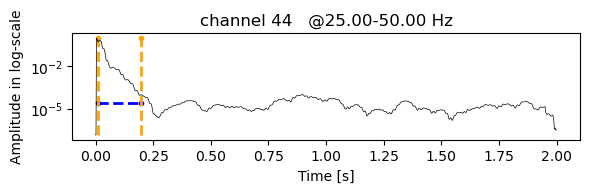

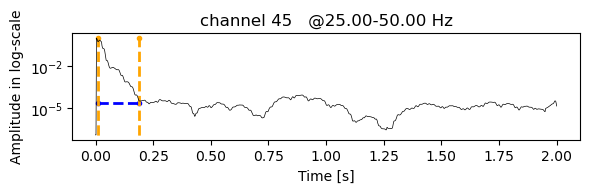

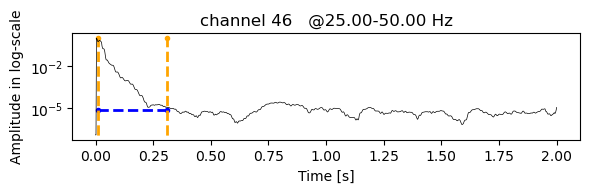

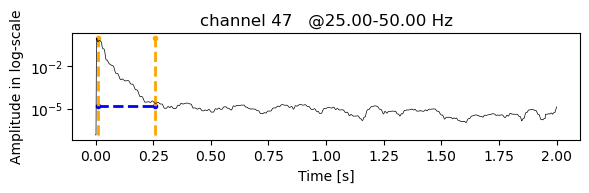

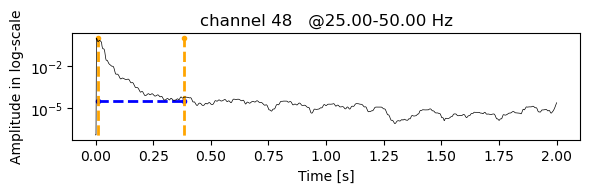

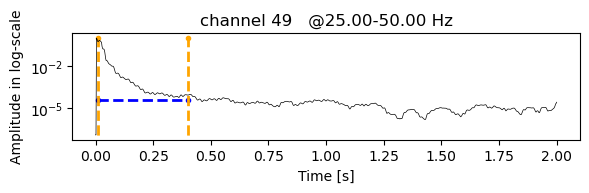

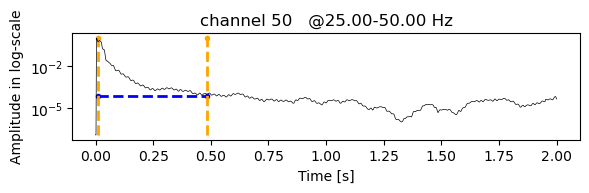

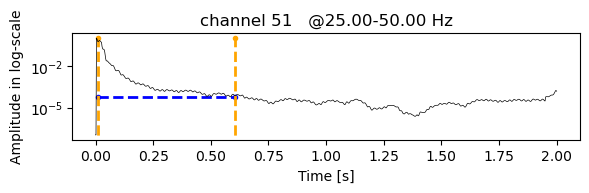

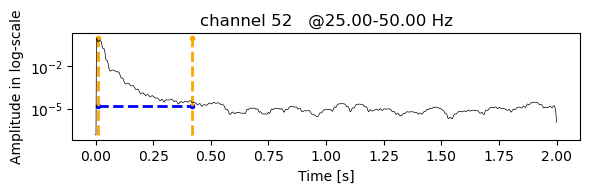

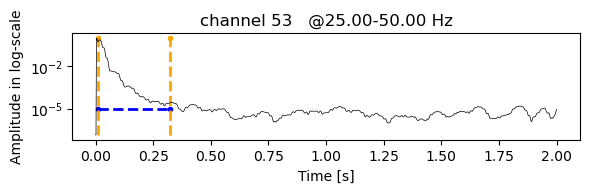

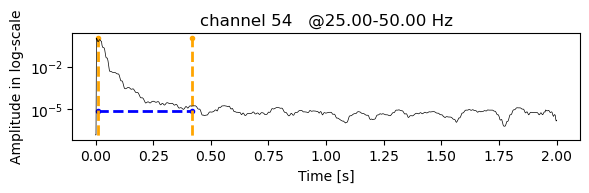

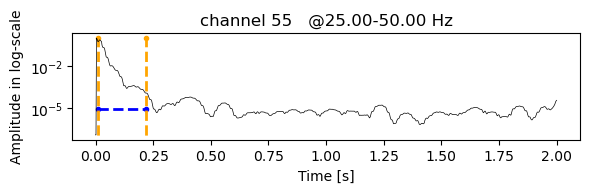

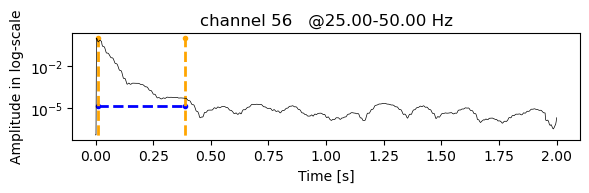

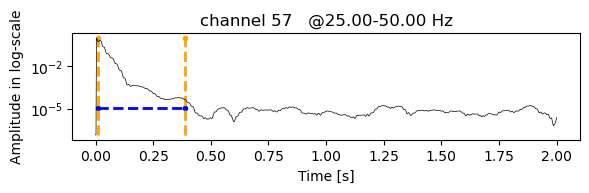

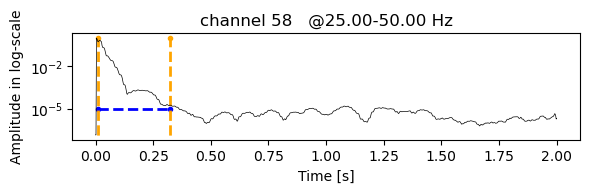

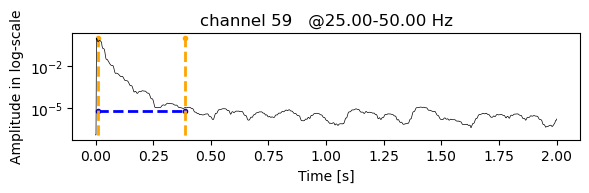

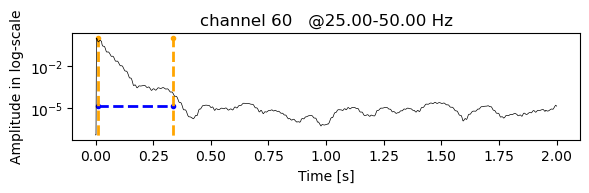

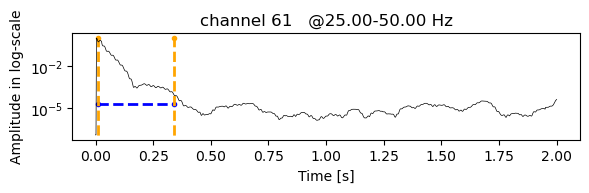

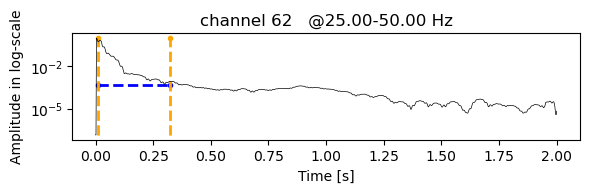

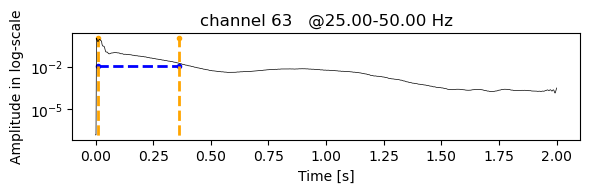

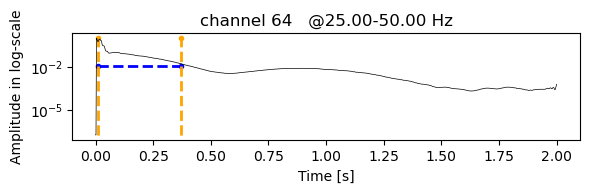

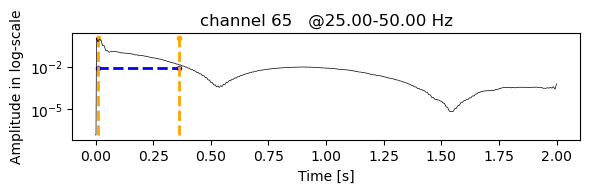

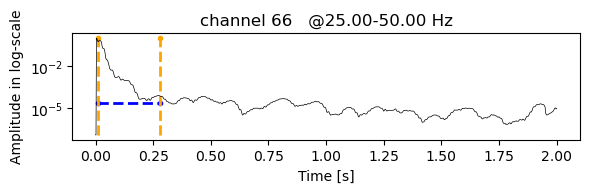

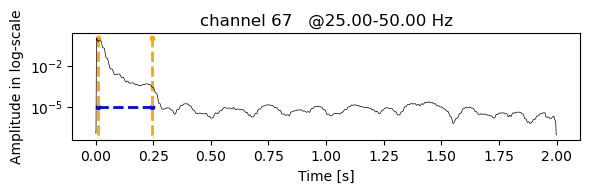

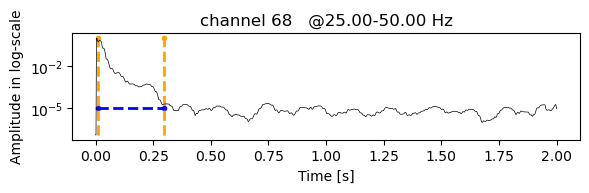

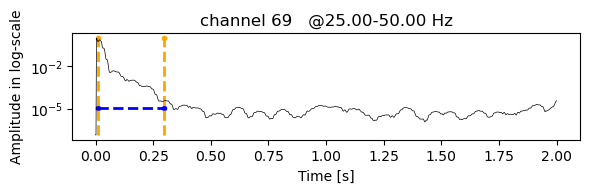

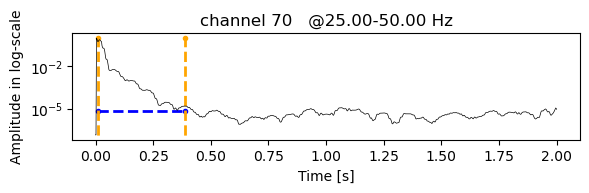

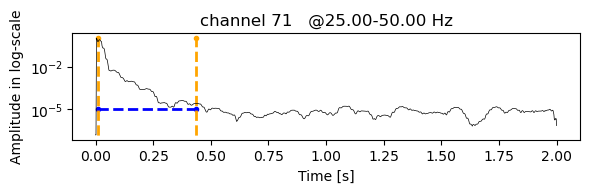

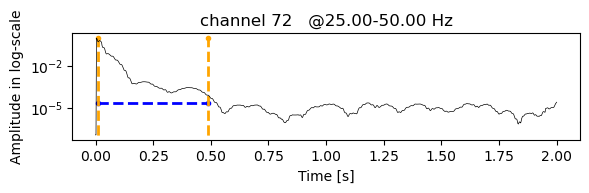

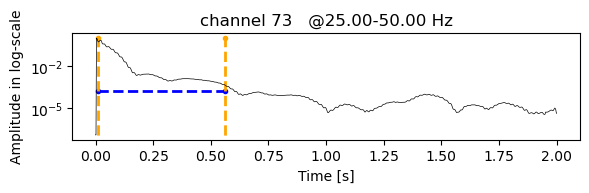

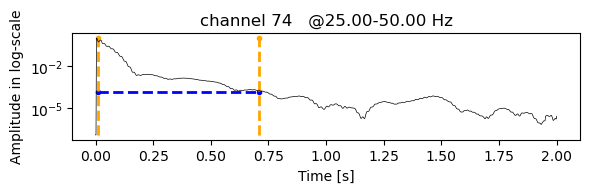

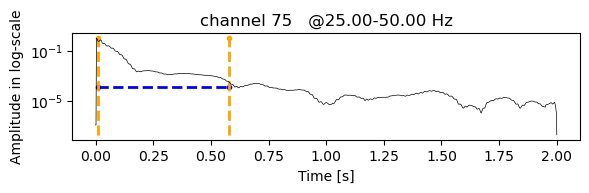

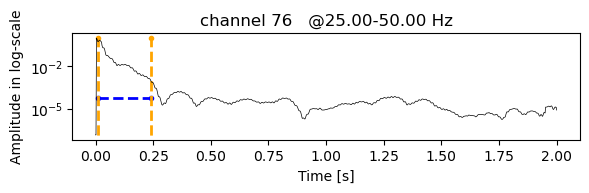

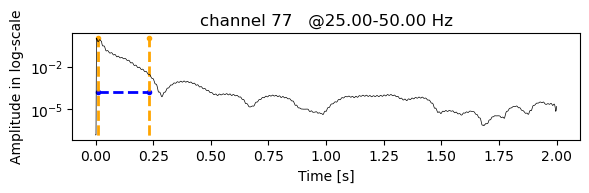

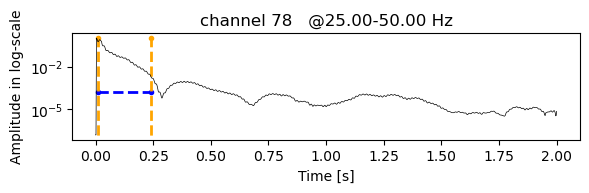

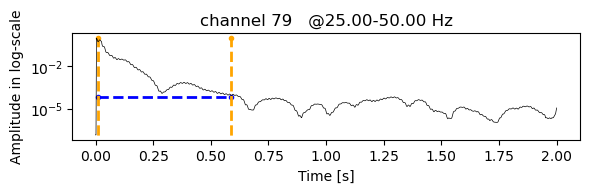

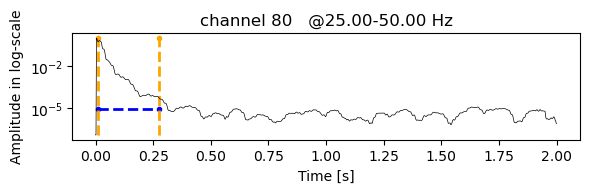

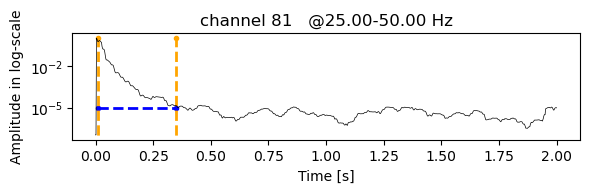

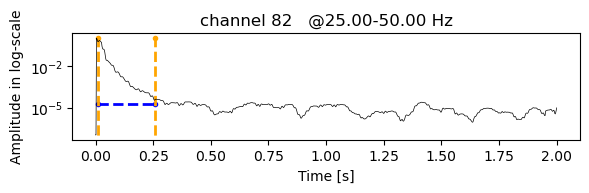

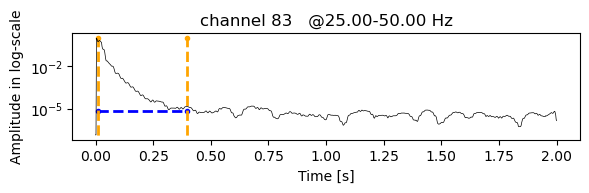

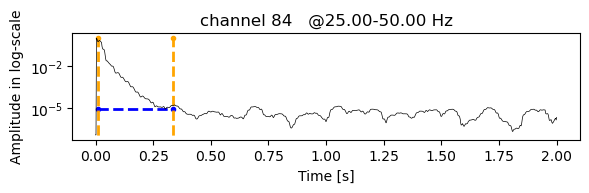

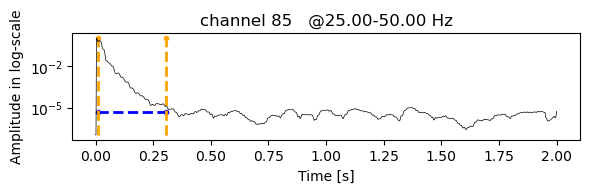

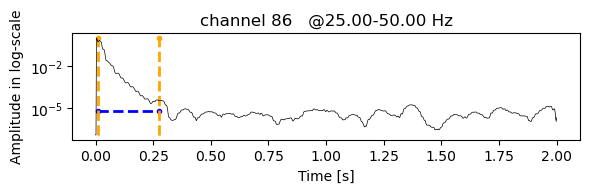

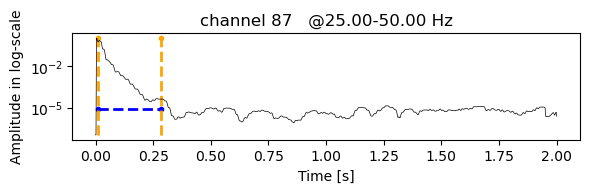

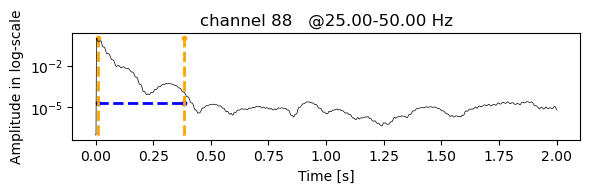

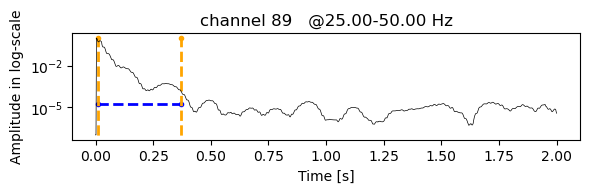

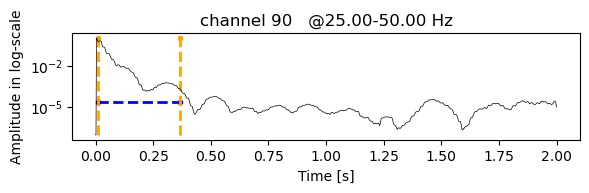

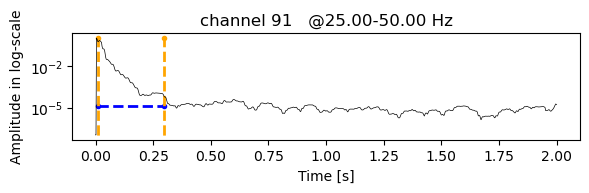

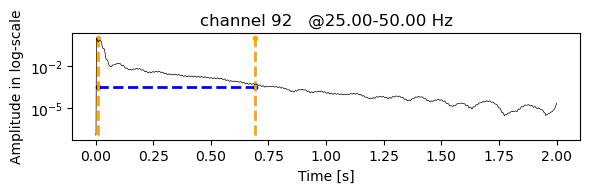

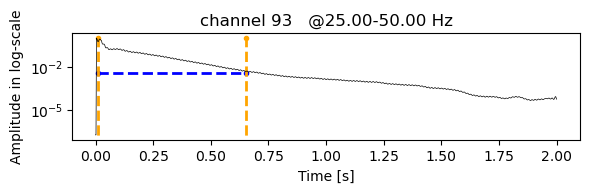

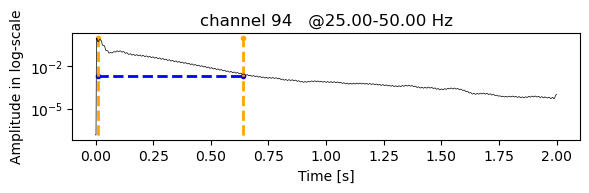

In [8]:
for chan in range(nlocs):
    chnm=locs[chan]
    plt.figure(figsize=(6,2))
    fmin=25
    fmax=50
    absy=1 #max(wav[fb], key=abs)
    plt.plot([twinbe[chan, 0],twinbe[chan,-1]],[level[chan],level[chan]],c='blue',marker='.',ls='--', linewidth=2)
    plt.plot([twinbe[chan, 0],twinbe[chan,0]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
    plt.plot([twinbe[chan, 1],twinbe[chan,1]],[-0.1,absy],c='orange',marker='.',ls='--', linewidth=2)
    plt.yscale('log', base=10)
    plt.plot(ptime,msv[chan], "k-", linewidth=0.5)
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude in log-scale")
    plt.title( "channel %s   @%4.2f-%4.2f Hz" % ( chnm,fmin,fmax ) )
    plt.tight_layout()
    plt.show()
    # plt.title("Channel "+str(chnm))
    # plt.ylabel('Window number')
    # plt.xlabel('Lag-time (sec)')
    # plt.tight_layout()    